# CS189 HW5
Timothy Quang Nguyen

timotqn2@uci.edu

## Environment Setup

In [1]:
# For package installations
!pip install xgboost
!pip install ucimlrepo
!pip install scikit-optimize

In [2]:
#Task: Predict grade of glioma for patients based on patient information.

import numpy as np # for data organization
import pandas as pd # for data organization

import sklearn as sk # for machine learning
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score # For Evaluation
from sklearn.preprocessing import MinMaxScaler # To Scale Features
from sklearn.preprocessing import OneHotEncoder # To Encode Non-Numeric Columns
from sklearn.model_selection import GridSearchCV, train_test_split # For Hyper Parameter Tuning and Data Splitting
from skopt import BayesSearchCV # For Smart Hyper Parameter Tuning

from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 
  
# metadata 
print(glioma_grading_clinical_and_mutation_features.metadata) 
  
# variable information 
print(glioma_grading_clinical_and_mutation_features.variables) 


{'uci_id': 759, 'name': 'Glioma Grading Clinical and Mutation Features', 'repository_url': 'https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/759/data.csv', 'abstract': 'Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.    In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.  The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading 

## Function Declaration

In [4]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred, label_nums, label_names):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

## Data Exploration

In [5]:
data = pd.concat([X, y], axis = 1) # Combining both the x and y data for exploration

data

,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Grade
0,0,51.30,white,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38.72,white,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,35.17,white,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,32.78,white,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,31.51,white,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,77.89,white,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
835,0,85.18,white,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
836,1,77.49,white,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
837,0,63.33,white,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [6]:
# General data properties

rows, cols = data.shape
column_names = data.columns.tolist()

print("Number of rows: ", rows)
print("Number of columns: ", cols)
print()
print("All Columns: ", column_names)
print()
print("Column Types: ", data.dtypes)

Number of rows:  839
Number of columns:  24

All Columns:  ['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA', 'Grade']

Column Types:  Gender                int64
Age_at_diagnosis    float64
Race                 object
IDH1                  int64
TP53                  int64
ATRX                  int64
PTEN                  int64
EGFR                  int64
CIC                   int64
MUC16                 int64
PIK3CA                int64
NF1                   int64
PIK3R1                int64
FUBP1                 int64
RB1                   int64
NOTCH1                int64
BCOR                  int64
CSMD3                 int64
SMARCA4               int64
GRIN2A                int64
IDH2                  int64
FAT4                  int64
PDGFRA                int64
Grade                 int64
dtype: object


In [7]:
# Display any missing data

missing_data = pd.DataFrame(data.isnull().sum())
missing_data.columns = ['Number of Missing']
missing_data = missing_data[missing_data['Number of Missing'] != 0]
print(missing_data)

Empty DataFrame
Columns: [Number of Missing]
Index: []


<Axes: xlabel='Grade', ylabel='Count'>

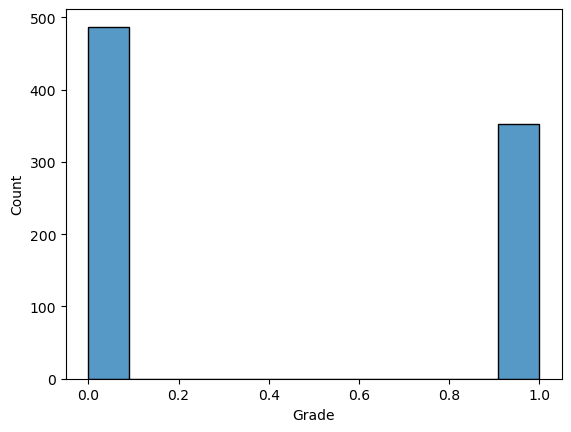

In [8]:
# Distribution of target data

sns.histplot(data['Grade'])

<Axes: xlabel='Age_at_diagnosis', ylabel='Count'>

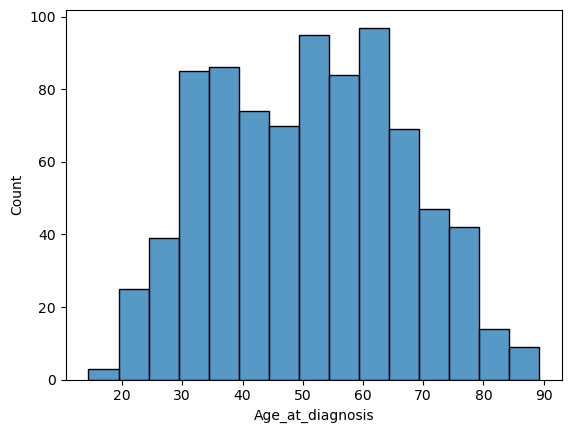

In [9]:
# Distribution of age data

sns.histplot(data['Age_at_diagnosis'])

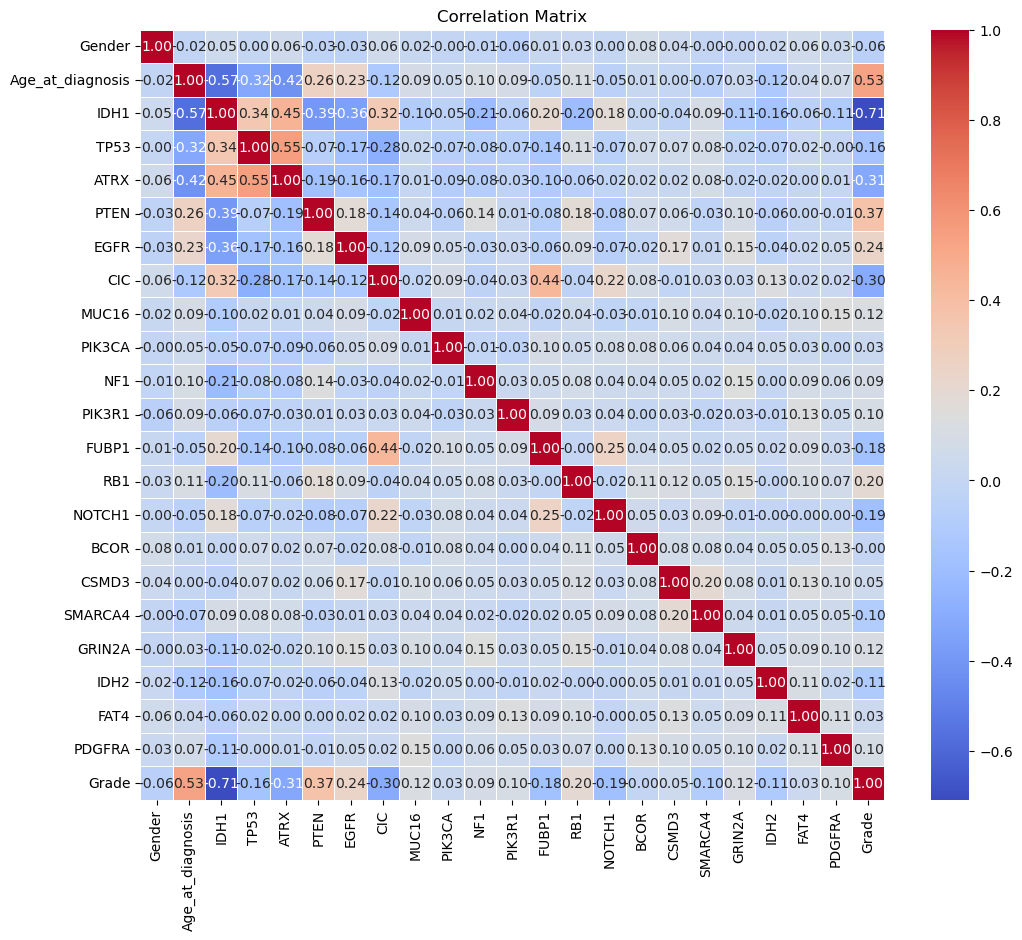

In [10]:
# Correlation heatmap for all columns
corr_matrix = data.drop('Race', axis=1).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5)
plt.title("Correlation Matrix")
plt.show()

## Data Preprocessing

### One Hot Encode Race Column

In [11]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_race = encoder.fit_transform(data[['Race']])
new_race_columns = pd.DataFrame(encoded_race, columns=['R1', 'R2', 'R3', 'R4'])

print(new_race_columns)

data = data.drop('Race', axis=1)
data = pd.concat([data, new_race_columns], axis=1)

print(data)

      R1   R2   R3   R4
0    0.0  0.0  0.0  1.0
1    0.0  0.0  0.0  1.0
2    0.0  0.0  0.0  1.0
3    0.0  0.0  0.0  1.0
4    0.0  0.0  0.0  1.0
..   ...  ...  ...  ...
834  0.0  0.0  0.0  1.0
835  0.0  0.0  0.0  1.0
836  0.0  0.0  0.0  1.0
837  0.0  0.0  0.0  1.0
838  0.0  0.0  1.0  0.0

[839 rows x 4 columns]
     Gender  Age_at_diagnosis  IDH1  TP53  ATRX  PTEN  EGFR  CIC  MUC16  \
0         0             51.30     1     0     0     0     0    0      0   
1         0             38.72     1     0     0     0     0    1      0   
2         0             35.17     1     1     1     0     0    0      0   
3         1             32.78     1     1     1     0     0    0      1   
4         0             31.51     1     1     1     0     0    0      0   
..      ...               ...   ...   ...   ...   ...   ...  ...    ...   
834       1             77.89     0     0     0     1     0    0      0   
835       0             85.18     0     1     0     1     0    0      0   
836       1  

### Scale Age Column

In [12]:
scaler = MinMaxScaler()
scaled_age = pd.DataFrame(scaler.fit_transform(data[['Age_at_diagnosis']]), columns=['Age_at_diagnosis'])

print(scaled_age)

data['Age_at_diagnosis'] = scaled_age

print(data)

     Age_at_diagnosis
0            0.492587
1            0.324563
2            0.277147
3            0.245225
4            0.228262
..                ...
834          0.847736
835          0.945105
836          0.842393
837          0.653266
838          0.830640

[839 rows x 1 columns]
     Gender  Age_at_diagnosis  IDH1  TP53  ATRX  PTEN  EGFR  CIC  MUC16  \
0         0          0.492587     1     0     0     0     0    0      0   
1         0          0.324563     1     0     0     0     0    1      0   
2         0          0.277147     1     1     1     0     0    0      0   
3         1          0.245225     1     1     1     0     0    0      1   
4         0          0.228262     1     1     1     0     0    0      0   
..      ...               ...   ...   ...   ...   ...   ...  ...    ...   
834       1          0.847736     0     0     0     1     0    0      0   
835       0          0.945105     0     1     0     1     0    0      0   
836       1          0.842393     0  

### Split X and Y Data

In [13]:
y_data = pd.DataFrame(data['Grade'])
x_data = data.drop('Grade', axis=1)

print(x_data)
print(y_data)

     Gender  Age_at_diagnosis  IDH1  TP53  ATRX  PTEN  EGFR  CIC  MUC16  \
0         0          0.492587     1     0     0     0     0    0      0   
1         0          0.324563     1     0     0     0     0    1      0   
2         0          0.277147     1     1     1     0     0    0      0   
3         1          0.245225     1     1     1     0     0    0      1   
4         0          0.228262     1     1     1     0     0    0      0   
..      ...               ...   ...   ...   ...   ...   ...  ...    ...   
834       1          0.847736     0     0     0     1     0    0      0   
835       0          0.945105     0     1     0     1     0    0      0   
836       1          0.842393     0     1     0     1     0    0      0   
837       0          0.653266     0     1     0     0     0    0      1   
838       0          0.830640     0     0     0     0     0    0      0   

     PIK3CA  ...  CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  PDGFRA   R1   R2   R3  \
0         1  ...    

### Split Train and Test Data

In [14]:
# Ratio 80% Training and 20% Testing
x_tr, x_te, y_tr, y_te = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, random_state=22)

print(x_tr.shape)
print(x_te.shape)
print(y_tr.shape)
print(y_te.shape)

(671, 26)
(168, 26)
(671, 1)
(168, 1)


## Logistic Regression

### Logistic Regression Default

In [15]:
# Linear Regression Model
lr_model = LogisticRegression(random_state=22)
lr_model.fit(x_tr, y_tr.values.ravel())
lr_y_pred = lr_model.predict(x_te)

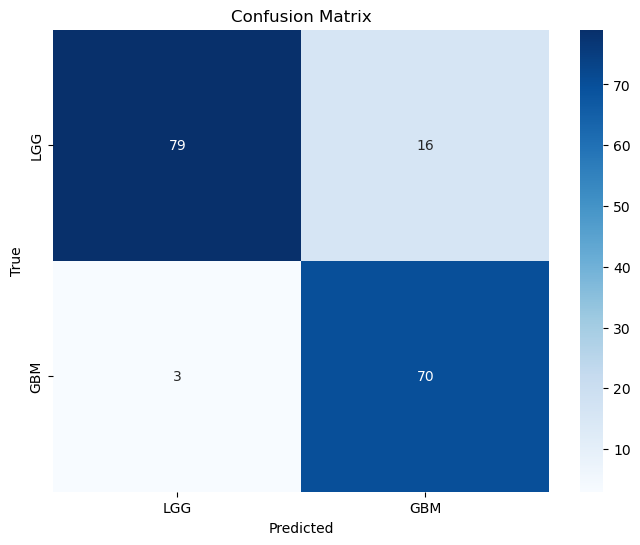

Precision of the MLP :	0.8886840612592173
Recall of the MLP    :	0.8952415284787311
F1 Score of the Model :	0.8865792559428632
Accuracy Score of the Model :	88.69%


In [16]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, lr_y_pred, [0, 1], ["LGG", "GBM"])

## Random Forest Classifier

### Random Forest Default

In [17]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=22)
rf_model.fit(x_tr, y_tr.values.ravel())
rf_y_pred = rf_model.predict(x_te)

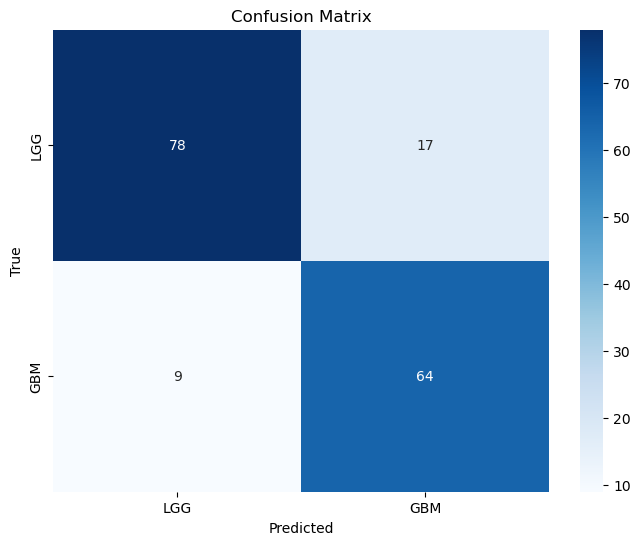

Precision of the MLP :	0.8433375904640272
Recall of the MLP    :	0.8488824801730352
F1 Score of the Model :	0.8441558441558441
Accuracy Score of the Model :	84.52%


In [18]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, rf_y_pred, [0, 1], ["LGG", "GBM"])

### Random Forest Tuned

In [19]:
# Use Bayesian Optimization to find the best set of hyperparameters
rf_params = {"n_estimators": (10, 500), 
              "max_features": ["sqrt", "log2", 0.2, 0.5, 0.7, 1],
              "max_depth": [3, 5, 10, 15, 20, None], 
              "min_samples_leaf": (1, 15)}

rf_opt = BayesSearchCV(RandomForestClassifier(random_state=22), rf_params, verbose=3, n_iter=100)
rf_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=132;, score=0.867 total time=   0.1s
[CV 2/5] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=132;, score=0.851 total time=   0.1s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=132;, score=0.836 total time=   0.1s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=132;, score=0.858 total time=   0.1s
[CV 5/5] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=132;, score=0.881 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=0.5, min_samples_leaf=9, n_estimators=70;, score=0.874 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=0.5, min_samples_leaf=9, n_estimators=70;, score=0.843 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=0.5, min_samples_leaf=9, n_

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.float64(0.7), np.int64(2), np.int64(500)] before, using random point [15, 1, np.int64(2), np.int64(212)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=1, min_samples_leaf=2, n_estimators=212;, score=0.867 total time=   0.2s
[CV 2/5] END max_depth=15, max_features=1, min_samples_leaf=2, n_estimators=212;, score=0.851 total time=   0.2s
[CV 3/5] END max_depth=15, max_features=1, min_samples_leaf=2, n_estimators=212;, score=0.843 total time=   0.2s
[CV 4/5] END max_depth=15, max_features=1, min_samples_leaf=2, n_estimators=212;, score=0.851 total time=   0.2s
[CV 5/5] END max_depth=15, max_features=1, min_samples_leaf=2, n_estimators=212;, score=0.873 total time=   0.2s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.float64(0.7), np.int64(2), np.int64(500)] before, using random point [None, 'sqrt', np.int64(7), np.int64(219)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=7, n_estimators=219;, score=0.867 total time=   0.2s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=7, n_estimators=219;, score=0.843 total time=   0.2s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=7, n_estimators=219;, score=0.836 total time=   0.2s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=7, n_estimators=219;, score=0.851 total time=   0.2s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=7, n_estimators=219;, score=0.873 total time=   0.2s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.float64(0.7), np.int64(2), np.int64(500)] before, using random point [3, 'log2', np.int64(9), np.int64(332)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=log2, min_samples_leaf=9, n_estimators=332;, score=0.867 total time=   0.3s
[CV 2/5] END max_depth=3, max_features=log2, min_samples_leaf=9, n_estimators=332;, score=0.843 total time=   0.3s
[CV 3/5] END max_depth=3, max_features=log2, min_samples_leaf=9, n_estimators=332;, score=0.836 total time=   0.3s
[CV 4/5] END max_depth=3, max_features=log2, min_samples_leaf=9, n_estimators=332;, score=0.858 total time=   0.3s
[CV 5/5] END max_depth=3, max_features=log2, min_samples_leaf=9, n_estimators=332;, score=0.881 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=0.2, min_samples_leaf=2, n_estimators=500;, score=0.867 total time=   0.6s
[CV 2/5] END max_depth=3, max_features=0.2, min_samples_leaf=2, n_estimators=500;, score=0.843 total time=   0.6s
[CV 3/5] END max_depth=3, max_features=0.2, min_samples_leaf=2, n_estimators=50

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.str_('log2'), np.int64(2), np.int64(500)] before, using random point [15, 0.2, np.int64(7), np.int64(124)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=124;, score=0.867 total time=   0.1s
[CV 2/5] END max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=124;, score=0.843 total time=   0.1s
[CV 3/5] END max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=124;, score=0.828 total time=   0.1s
[CV 4/5] END max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=124;, score=0.858 total time=   0.1s
[CV 5/5] END max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=124;, score=0.873 total time=   0.1s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('log2'), np.int64(2), np.int64(500)] before, using random point [15, 'log2', np.int64(6), np.int64(326)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=log2, min_samples_leaf=6, n_estimators=326;, score=0.867 total time=   0.3s
[CV 2/5] END max_depth=15, max_features=log2, min_samples_leaf=6, n_estimators=326;, score=0.843 total time=   0.3s
[CV 3/5] END max_depth=15, max_features=log2, min_samples_leaf=6, n_estimators=326;, score=0.836 total time=   0.4s
[CV 4/5] END max_depth=15, max_features=log2, min_samples_leaf=6, n_estimators=326;, score=0.858 total time=   0.4s
[CV 5/5] END max_depth=15, max_features=log2, min_samples_leaf=6, n_estimators=326;, score=0.873 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=500;, score=0.874 total time=   0.6s
[CV 2/5] END max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=500;, score=0.851 total time=   0.5s
[CV 3/5] END max_depth=3, max_features=log2, min_samples_leaf=1, n_estim

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('log2'), np.int64(1), np.int64(500)] before, using random point [15, 'log2', np.int64(2), np.int64(498)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=498;, score=0.867 total time=   0.6s
[CV 2/5] END max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=498;, score=0.858 total time=   0.6s
[CV 3/5] END max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=498;, score=0.836 total time=   0.6s
[CV 4/5] END max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=498;, score=0.866 total time=   0.6s
[CV 5/5] END max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=498;, score=0.866 total time=   0.6s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('log2'), np.int64(2), np.int64(500)] before, using random point [None, 'log2', np.int64(6), np.int64(476)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=log2, min_samples_leaf=6, n_estimators=476;, score=0.867 total time=   0.6s
[CV 2/5] END max_depth=None, max_features=log2, min_samples_leaf=6, n_estimators=476;, score=0.843 total time=   0.6s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_leaf=6, n_estimators=476;, score=0.836 total time=   0.6s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_leaf=6, n_estimators=476;, score=0.866 total time=   0.6s
[CV 5/5] END max_depth=None, max_features=log2, min_samples_leaf=6, n_estimators=476;, score=0.873 total time=   0.5s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('log2'), np.int64(2), np.int64(500)] before, using random point [10, 'log2', np.int64(13), np.int64(282)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=10, max_features=log2, min_samples_leaf=13, n_estimators=282;, score=0.867 total time=   0.3s
[CV 2/5] END max_depth=10, max_features=log2, min_samples_leaf=13, n_estimators=282;, score=0.843 total time=   0.3s
[CV 3/5] END max_depth=10, max_features=log2, min_samples_leaf=13, n_estimators=282;, score=0.828 total time=   0.3s
[CV 4/5] END max_depth=10, max_features=log2, min_samples_leaf=13, n_estimators=282;, score=0.858 total time=   0.3s
[CV 5/5] END max_depth=10, max_features=log2, min_samples_leaf=13, n_estimators=282;, score=0.873 total time=   0.3s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('log2'), np.int64(2), np.int64(500)] before, using random point [10, 1, np.int64(3), np.int64(114)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=10, max_features=1, min_samples_leaf=3, n_estimators=114;, score=0.859 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=1, min_samples_leaf=3, n_estimators=114;, score=0.851 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=1, min_samples_leaf=3, n_estimators=114;, score=0.843 total time=   0.1s
[CV 4/5] END max_depth=10, max_features=1, min_samples_leaf=3, n_estimators=114;, score=0.851 total time=   0.1s
[CV 5/5] END max_depth=10, max_features=1, min_samples_leaf=3, n_estimators=114;, score=0.881 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=0.7, min_samples_leaf=4, n_estimators=500;, score=0.874 total time=   0.7s
[CV 2/5] END max_depth=5, max_features=0.7, min_samples_leaf=4, n_estimators=500;, score=0.858 total time=   0.7s
[CV 3/5] END max_depth=5, max_features=0.7, min_samples_leaf=4, n_estimators=500;, score=

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.float64(0.7), np.int64(4), np.int64(500)] before, using random point [None, 'sqrt', np.int64(6), np.int64(200)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=6, n_estimators=200;, score=0.867 total time=   0.2s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=6, n_estimators=200;, score=0.843 total time=   0.2s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=6, n_estimators=200;, score=0.836 total time=   0.2s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=6, n_estimators=200;, score=0.858 total time=   0.2s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=6, n_estimators=200;, score=0.873 total time=   0.2s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.float64(0.7), np.int64(3), np.int64(500)] before, using random point [20, 1, np.int64(9), np.int64(17)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, max_features=1, min_samples_leaf=9, n_estimators=17;, score=0.800 total time=   0.0s
[CV 2/5] END max_depth=20, max_features=1, min_samples_leaf=9, n_estimators=17;, score=0.813 total time=   0.0s
[CV 3/5] END max_depth=20, max_features=1, min_samples_leaf=9, n_estimators=17;, score=0.799 total time=   0.0s
[CV 4/5] END max_depth=20, max_features=1, min_samples_leaf=9, n_estimators=17;, score=0.776 total time=   0.0s
[CV 5/5] END max_depth=20, max_features=1, min_samples_leaf=9, n_estimators=17;, score=0.806 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=500;, score=0.852 total time=   0.8s
[CV 2/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=500;, score=0.836 total time=   0.8s
[CV 3/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=500;, score=0.

BayesSearchCV(estimator=RandomForestClassifier(random_state=22), n_iter=100,
              search_spaces={'max_depth': [3, 5, 10, 15, 20, None],
                             'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.7, 1],
                             'min_samples_leaf': (1, 15),
                             'n_estimators': (10, 500)},
              verbose=3)

In [20]:
# Random Forest Classifier Model
print(rf_opt.best_estimator_)
rf_model_tuned = rf_opt.best_estimator_
rf_tuned_y_pred = rf_model_tuned.predict(x_te)

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=3,
                       n_estimators=500, random_state=22)


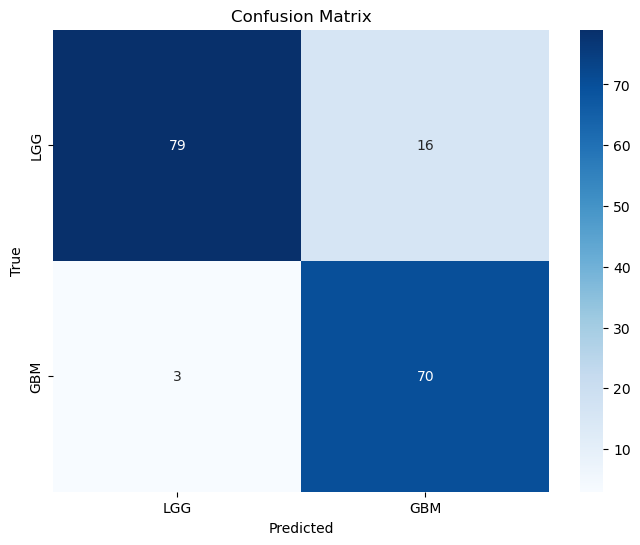

Precision of the MLP :	0.8886840612592173
Recall of the MLP    :	0.8952415284787311
F1 Score of the Model :	0.8865792559428632
Accuracy Score of the Model :	88.69%


In [21]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, rf_tuned_y_pred, [0, 1], ["LGG", "GBM"])

## Support Vector Classifier (SVC)

### SVC Default

In [22]:
# SVC Model
svc_model = SVC(random_state=22)
svc_model.fit(x_tr, y_tr.values.ravel())
svc_y_pred = svc_model.predict(x_te)

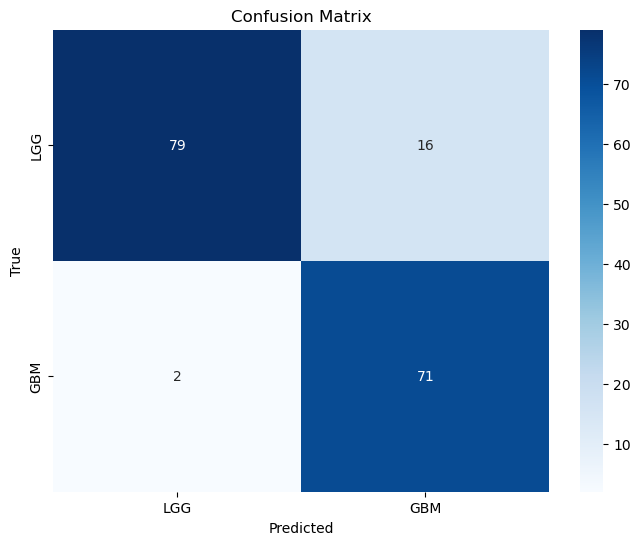

Precision of the MLP :	0.8957002979991486
Recall of the MLP    :	0.9020908435472242
F1 Score of the Model :	0.8926136363636363
Accuracy Score of the Model :	89.29%


In [23]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, svc_y_pred, [0, 1], ["LGG", "GBM"])

### SVC Tuned

In [24]:
# Use Bayesian Optimization to find the best set of hyperparameters
svc_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"], 
            "degree": (0, 10), 
            "gamma": ["scale", "auto", 1, 0.1, 0.001, 0.0001], 
            "C": (0.001, 1000)}

svc_opt = BayesSearchCV(SVC(random_state=22), svc_params, verbose=3, n_iter=100)
svc_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=558.4886885021459, degree=7, gamma=1, kernel=linear;, score=0.852 total time=   7.5s
[CV 2/5] END C=558.4886885021459, degree=7, gamma=1, kernel=linear;, score=0.858 total time=   4.0s
[CV 3/5] END C=558.4886885021459, degree=7, gamma=1, kernel=linear;, score=0.858 total time=   3.2s
[CV 4/5] END C=558.4886885021459, degree=7, gamma=1, kernel=linear;, score=0.843 total time=   3.2s
[CV 5/5] END C=558.4886885021459, degree=7, gamma=1, kernel=linear;, score=0.888 total time=   4.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=881.7562600683384, degree=3, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 2/5] END C=881.7562600683384, degree=3, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/5] END C=881.7562600683384, degree=3, gamma=0.1, kernel=sigmoid;, score=0.791 total time=   0.0s
[CV 4/5] END C=881.7562600683384, degree=3, gamma=0.1, kernel=sigmoid;, s

BayesSearchCV(estimator=SVC(random_state=22), n_iter=100,
              search_spaces={'C': (0.001, 1000), 'degree': (0, 10),
                             'gamma': ['scale', 'auto', 1, 0.1, 0.001, 0.0001],
                             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              verbose=3)

In [25]:
# SVC Model
print(svc_opt.best_estimator_)
svc_model_tuned = svc_opt.best_estimator_
svc_tuned_y_pred = svc_model_tuned.predict(x_te)

SVC(C=31.591338916049608, degree=10, gamma='auto', kernel='sigmoid',
    random_state=22)


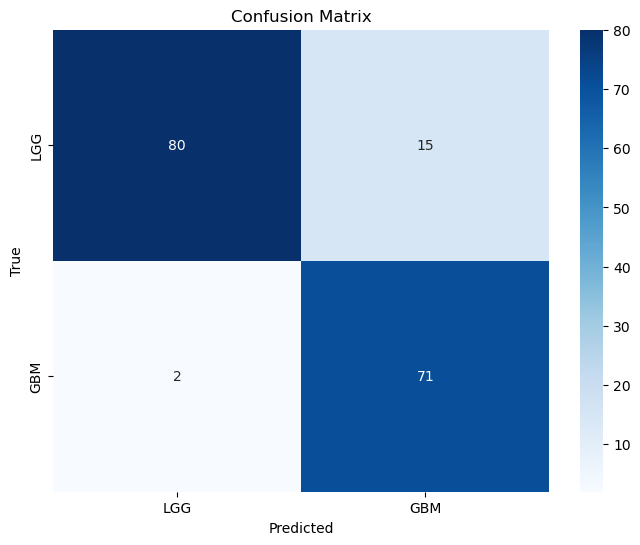

Precision of the MLP :	0.9005955757231991
Recall of the MLP    :	0.907354001441961
F1 Score of the Model :	0.8985182816330881
Accuracy Score of the Model :	89.88%


In [26]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, svc_tuned_y_pred, [0, 1], ["LGG", "GBM"])

## XGB Classifier

### XGB Default

In [27]:
# XGB Model
xgb_model = XGBClassifier(random_state=22)
xgb_model.fit(x_tr, y_tr.values.ravel())
xgb_y_pred = xgb_model.predict(x_te)

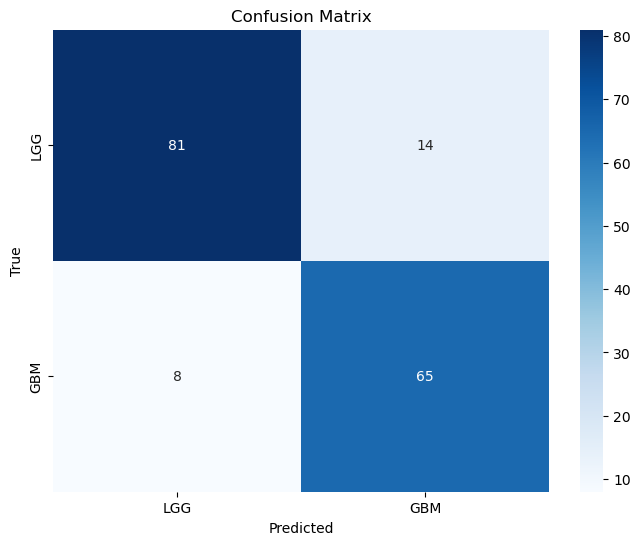

Precision of the MLP :	0.8664485848385721
Recall of the MLP    :	0.871521268925739
F1 Score of the Model :	0.8678489702517163
Accuracy Score of the Model :	86.9%


In [28]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, xgb_y_pred, [0, 1], ["LGG", "GBM"])

### XGB Tuned

In [29]:
# Use Bayesian Optimization to find the best set of hyperparameters
xgb_params = {"n_estimators": (10, 500), 
              "eta": (0.0001, 1),
              "max_depth": (1, 9), 
              "subsample": (0.1, 1), 
              "colsample_bytree": (0.1, 1)}

xgb_opt = BayesSearchCV(XGBClassifier(random_state=22), xgb_params, verbose=3, n_iter=100)
xgb_opt.fit(x_tr, y_tr.values.ravel())
xgb_opt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.16978615806902983, eta=0.5305104401659754, max_depth=9, n_estimators=285, subsample=0.15538014472170883;, score=0.785 total time=   0.2s
[CV 2/5] END colsample_bytree=0.16978615806902983, eta=0.5305104401659754, max_depth=9, n_estimators=285, subsample=0.15538014472170883;, score=0.799 total time=   0.2s
[CV 3/5] END colsample_bytree=0.16978615806902983, eta=0.5305104401659754, max_depth=9, n_estimators=285, subsample=0.15538014472170883;, score=0.761 total time=   0.2s
[CV 4/5] END colsample_bytree=0.16978615806902983, eta=0.5305104401659754, max_depth=9, n_estimators=285, subsample=0.15538014472170883;, score=0.776 total time=   0.2s
[CV 5/5] END colsample_bytree=0.16978615806902983, eta=0.5305104401659754, max_depth=9, n_estimators=285, subsample=0.15538014472170883;, score=0.806 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.21410

OrderedDict([('colsample_bytree', 0.1),
             ('eta', 0.09054730400017982),
             ('max_depth', 1),
             ('n_estimators', 361),
             ('subsample', 0.95267531002662)])

In [30]:
# XGB Model
print(xgb_opt.best_estimator_)
xgb_model_tuned = xgb_opt.best_estimator_
xgb_tuned_y_pred = xgb_model_tuned.predict(x_te)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.09054730400017982,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=361, n_jobs=None, ...)


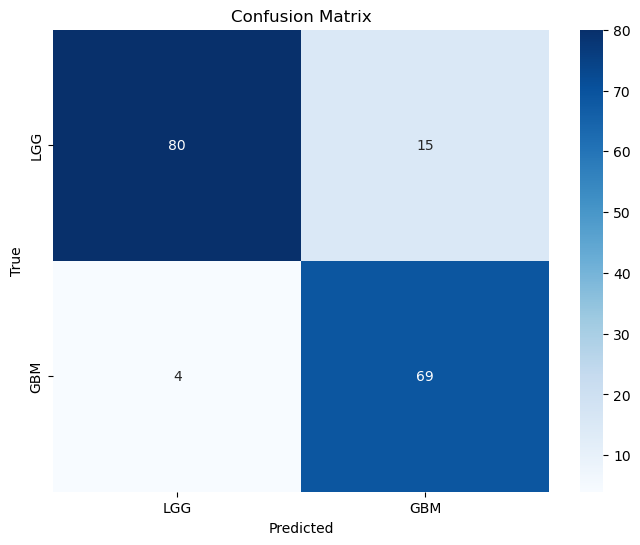

Precision of the MLP :	0.8869047619047619
Recall of the MLP    :	0.8936553713049747
F1 Score of the Model :	0.8864178201615486
Accuracy Score of the Model :	88.69%


In [31]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, xgb_tuned_y_pred, [0, 1], ["LGG", "GBM"])

## Model Comparison

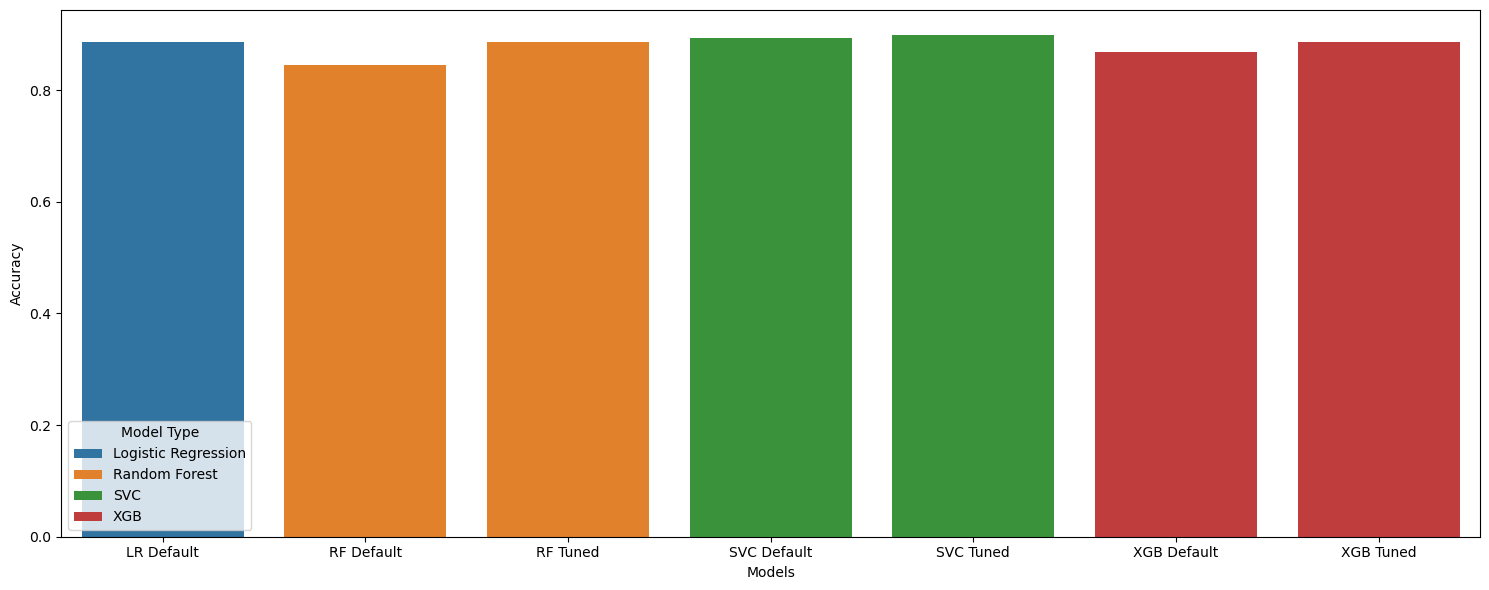

In [32]:
models = ["LR Default",  
          "RF Default", 
          "RF Tuned", 
          "SVC Default", 
          "SVC Tuned", 
          "XGB Default", 
          "XGB Tuned"]

accuracies = [accuracy_score(y_te, lr_y_pred), 
          accuracy_score(y_te, rf_y_pred), 
          accuracy_score(y_te, rf_tuned_y_pred), 
          accuracy_score(y_te, svc_y_pred), 
          accuracy_score(y_te, svc_tuned_y_pred), 
          accuracy_score(y_te, xgb_y_pred), 
          accuracy_score(y_te, xgb_tuned_y_pred)]

model_type = ["Logistic Regression", 
              "Random Forest", "Random Forest", 
              "SVC", "SVC", 
              "XGB", "XGB"]

comparison_data = pd.DataFrame({"Model Type": model_type, "Accuracy": accuracies, "Models": models})

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="Models", y="Accuracy", data=comparison_data, hue="Model Type", ax=ax)
sns.move_legend(ax, "lower left")
plt.tight_layout()
plt.show()

## Discussion

For this dataset all models performed surprisingly well with accuracies all above 80%. The most successful models were Logistic Regression and Support Vector Classifier (SVC) with accuracies above 88%. Random Forest and XGB performed worse with 84% and 86% respectively. This likely indicates that tree models are not as effective for this dataset compared to the other algorithmic models. Hyper parameter tuning was very effective with the usage of Bayesian optimization and improved all models. It brought Random Forest and XGB up to the 88% mark and increased SVC slightly. The most well performing model was SVC Tuned which had an accuracy of 89.88%. The fact that all models reached the threshold of 88% but didn't exceed towards the 90 range means the models have reach a soft limit with the current data organization. For further improvement, advance feature engineering would be required or the introduction of more data.

## References

1. Scikit Learn: One Hot Encoder Documentation
2. Scikit Learn: Min Max Scaler Documentation
3. Scikit Optimize: Bayes Search CV Documentation

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html